In [1]:
import dgl
from dgl.data import DGLDataset
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import dgl.data
from dgl.nn import GraphConv
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
import numpy as np
import time
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import os

%matplotlib inline

In [2]:
#トレーニング用データセットクラス
class CIFAR10TrainDataset(DGLDataset):
    def __init__(self,data_path):
        self.data_path = data_path
        super().__init__(name='cifar10_train__gprah')
    
    def process(self):
        GRAPHS, LABELS = dgl.load_graphs(self.data_path) #保存したグラーフデータの読み込み
        self.graphs = GRAPHS #グラフリストを代入
        self.labels = LABELS['label'] #ラベル辞書の値のみ代入

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

    def __len__(self):
        return len(self.graphs)


class CIFAR10TestDataset(DGLDataset):
    def __init__(self,data_path):
        self.data_path = data_path
        super().__init__(name='cifar10_test_gprah')
    
    def process(self):
        GRAPHS, LABELS = dgl.load_graphs(self.data_path) #保存したグラーフデータの読み込み
        self.graphs = GRAPHS #グラフリストを代入
        self.labels = LABELS['label'] #ラベル辞書の値のみ代入

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

    def __len__(self):
        return len(self.graphs)

In [3]:
path = "./data/MyDataset/train_graphs_six_f_in_pos_50_std.dgl"
traindataset = CIFAR10TrainDataset("./data/NewMyData/train_dist_40_std_full.dgl")
testdataset = CIFAR10TestDataset("./data/NewMyData/test_dist_40_std_full.dgl")

In [4]:
if os.name =='posix':
    num_workers = 2
else:
    num_workers = 0
num_workers = 0
traindataloader = GraphDataLoader(traindataset,batch_size = 2500,shuffle = True,num_workers = num_workers,pin_memory = True)
testdataloader = GraphDataLoader(testdataset,batch_size = 5000,shuffle = True,num_workers = num_workers,pin_memory = True)
print(f'num_wokers = {num_workers}')
print(os.name)

num_wokers = 0
posix


In [70]:
print(traindataset[0][0].ndata['feat value'].shape)
for i in range(5):
    print(traindataset[3][0].ndata['feat value'][i])
print(traindataset[9][0].ndata['feat value'])
print(traindataset)

torch.Size([20, 20])
tensor([ 0.0000,  3.6056,  6.7082, 10.0499,  9.4868,  8.2462,  9.2195,  1.4142,
         5.8310,  4.0000, 10.1980,  4.1231,  7.6158,  8.5440,  5.0000,  3.0000,
         1.0000,  3.1623,  2.2361,  2.0000])
tensor([3.6056, 0.0000, 4.0000, 7.6158, 7.8102, 6.4031, 7.2111, 2.2361, 3.0000,
        2.2361, 8.0623, 1.4142, 6.4031, 7.0711, 2.0000, 2.0000, 2.8284, 1.0000,
        1.4142, 2.2361])
tensor([ 6.7082,  4.0000,  0.0000,  9.8995, 10.8167,  9.4340, 10.0000,  5.3852,
         1.0000,  6.0828, 10.6301,  5.0990,  9.8489, 10.2956,  2.0000,  6.0000,
         6.3246,  5.0000,  5.0990,  6.0828])
tensor([10.0499,  7.6158,  9.8995,  0.0000,  2.2361,  2.2361,  1.4142,  9.2195,
         9.2195,  6.0828,  1.0000,  6.3246,  3.6056,  2.8284,  8.6023,  7.0711,
         9.0554,  7.2801,  8.2462,  8.0623])
tensor([ 9.4868,  7.8102, 10.8167,  2.2361,  0.0000,  1.4142,  1.0000,  8.9443,
        10.0000,  5.8310,  1.4142,  6.4031,  2.0000,  1.0000,  9.2195,  6.7082,
         8.5440,  7

In [50]:
print(traindataset)
print(traindataset[0][0].ndata['feat value'].shape)
for i in range(5):
    print(traindataset[3][0].ndata['feat value'][i])

Dataset("cifar10_train__gprah", num_graphs=20000, save_path=C:\Users\kisim\.dgl\cifar10_train__gprah)
torch.Size([5, 5])
tensor([0.0000, 2.0000, 1.0000, 1.4142, 1.0000])
tensor([2.0000, 0.0000, 2.2361, 1.4142, 1.0000])
tensor([1.0000, 2.2361, 0.0000, 1.0000, 1.4142])
tensor([1.4142, 1.4142, 1.0000, 0.0000, 1.0000])
tensor([1.0000, 1.0000, 1.4142, 1.0000, 0.0000])


In [22]:
#ネットワーク設定
class GCN(nn.Module):
    def __init__(self):
        super(GCN,self).__init__()
        self.conv1 = GraphConv(40,16)
        self.conv2 = GraphConv(16,32)
        self.conv3 = GraphConv(32,128)
        self.conv4 = GraphConv(64,128)
        self.dropout =nn.Dropout(0.4)
        self.meanpooling = nn.AvgPool1d(2)
        self.maxpooling = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32,10)


    def forward(self,g,n_feat,e_feat = None):
        h = self.conv1(g,n_feat,None,e_feat)
        h = self.conv2(g,h,None,e_feat)
        #h = self.dropout(h)
        h = self.conv3(g,h,None,e_feat)

        #h = self.meanpooling(h)
        h = self.maxpooling(h)

        h = self.flatten(h)

        h = F.relu(self.fc1(h))
        h = self.dropout(h)
        h = F.relu(self.fc2(h))
        h = self.dropout(h)
        h = F.relu(self.fc3(h))
        h = self.fc4(h)
        



        g.ndata['h'] = h

        return dgl.mean_nodes(g,'h')
        #return dgl.softmax_nodes(g,'h')

In [5]:
#ネットワーク設定
class GCNv2(nn.Module):
    def __init__(self):
        super(GCNv2,self).__init__()
        self.conv1 = GraphConv(40,60)
        self.conv2 = GraphConv(60,100)
        self.conv3 = GraphConv(100,120)
        self.conv4 = GraphConv(64,128)
        self.dropout =nn.Dropout(0.5)
        self.meanpooling = nn.AvgPool1d(2)
        self.maxpooling = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(60,60)
        self.fc2 = nn.Linear(60,60)
        self.fc3 = nn.Linear(60,32)
        self.fc4 = nn.Linear(32,10)


    def forward(self,g,n_feat,e_feat = None):
        h = self.conv1(g,n_feat,None,e_feat)
        h = self.dropout(h)
        h = self.conv2(g,h,None,e_feat)
        h = self.dropout(h)
        h = self.conv3(g,h,None,e_feat)

        #h = self.meanpooling(h)
        h = self.maxpooling(h)

        h = self.flatten(h)

        h = F.relu(self.fc1(h))
        h = self.dropout(h)
        h = F.relu(self.fc2(h))
        h = self.dropout(h)
        h = F.relu(self.fc3(h))
        h = self.fc4(h)
        



        g.ndata['h'] = h

        return dgl.mean_nodes(g,'h')
        #return dgl.softmax_nodes(g,'h')

In [ ]:
# 16 32 64 128 x4 '''

In [ ]:
model = GCN()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(),lr = 0.008)
#optimizer = optim.SGD(params=model.parameters(),lr=0.03,momentum=0.9)
epochs = 20

In [11]:
model = GCNv2()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(),lr = 0.008)
#optimizer = optim.SGD(params=model.parameters(),lr=0.03,momentum=0.9)
epochs = 100

In [7]:
save_train_acc = []
save_test_acc = []

In [12]:
loss_list = []
acc_list = []
test_acc_list = []


num_correct = 0
num_tests = 0
test_num_correct = 0
test_num_tests = 0
lossF = nn.CrossEntropyLoss()
#,batched_graph.edata['distance'].float()
BP = 0
for epoch in tqdm(range(epochs)):
    if BP != 0:
        break
    model.train()
    for batched_graph, labels in traindataloader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        pred = model(batched_graph, batched_graph.ndata['feat value'].float())
        loss = lossF(pred,labels)
        if loss.item() < 0.05:
            BP = 0
            break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    loss_list.append(loss.item())
    acc_list.append(num_correct / num_tests)
    
    model.eval()
    for tbatched_graph, tlabels in testdataloader:
        tbatched_graph = tbatched_graph.to(device)
        tlabels = tlabels.to(device)
        tpred = model(tbatched_graph, tbatched_graph.ndata['feat value'])
        test_num_correct += (tpred.argmax(1) == tlabels).sum().item()
        test_num_tests += len(tlabels)

    Tacc = test_num_correct / test_num_tests
    #print('Training accuracy:', Tacc)
    test_acc_list.append(Tacc)

num_correct = 0
num_tests = 0



with torch.no_grad():
    model.train()
    for batched_graph, labels in traindataloader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        pred = model(batched_graph, batched_graph.ndata['feat value'])
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    print('Training accuracy:', num_correct / num_tests)
    save_train_acc.append(num_correct / num_tests)
    num_correct = 0
    num_tests = 0
    model.eval()
    for batched_graph, labels in testdataloader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        pred = model(batched_graph, batched_graph.ndata['feat value'].float())
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    print('Test accuracy:', num_correct / num_tests)
    save_test_acc.append(num_correct / num_tests)

100%|██████████| 100/100 [03:37<00:00,  2.17s/it]


Training accuracy: 0.14698
Test accuracy: 0.1242


In [21]:
print(pred.shape)
print(pred[0])
print(pred[0].softmax(dim = 0))
print(sum(pred[0]))
print(sum(pred[0].softmax(dim = 0)))


torch.Size([5000, 10])
tensor([ 0.3780, -2.4598,  0.6290, -0.0913,  1.1682,  0.5908, -0.1727,  0.4545,
        -0.8756, -0.7732], device='cuda:0')
tensor([0.1154, 0.0068, 0.1483, 0.0722, 0.2542, 0.1427, 0.0665, 0.1245, 0.0329,
        0.0365], device='cuda:0')
tensor(-1.1520, device='cuda:0')
tensor(1., device='cuda:0')


In [9]:
#5:40
#3:15
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(loss)
print(max(test_acc_list))

True
1
tensor(2.0764, device='cuda:0', grad_fn=<NllLossBackward0>)
0.13063432835820896


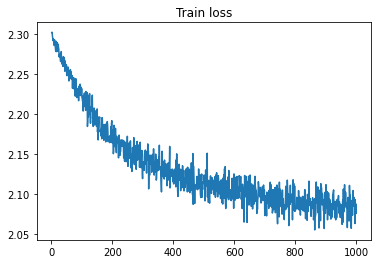

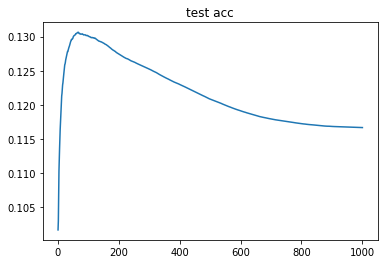

In [10]:
x = [p for p in range(1,len(loss_list)+1)]
y = loss_list
plt.plot(x,y)
plt.title('Train loss')
plt.show()
plt.plot(x,test_acc_list)
plt.title('test acc')
plt.show()

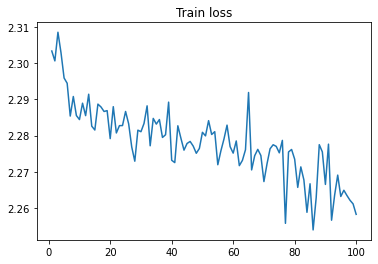

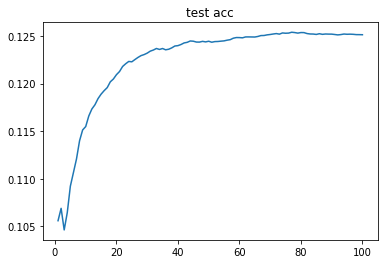

In [13]:
x = [p for p in range(1,len(loss_list)+1)]
y = loss_list
plt.plot(x,y)
plt.title('Train loss')
plt.show()
plt.plot(x,test_acc_list)
plt.title('test acc')
plt.show()

In [15]:
save_model_path = '4000epoch.pth'
torch.save(model.state_dict(),save_model_path)

In [14]:
print(type(loss_list))
print(save_train_acc)
print(save_test_acc)

<class 'list'>
[0.24014, 0.14698]
[0.1149, 0.1242]


In [50]:
np.save(file='10000loss_list',arr=loss_list)

In [ ]:
x = [p for p in range(1,len(loss_list)+1)]
y1 = acc_list
y2 = test_acc_list
plt.ylim(0,1)
'''
#20
plt.plot(x,train_acc_lists[0],label = '20 Train acc', color = "crimson")
plt.plot(x,test_acc_lists[0],label = '20 Test acc', color = "crimson",linestyle = 'dashed')

#30
plt.plot(x,train_acc_lists[1],label = '30 Train acc', color = "darkblue")
plt.plot(x,test_acc_lists[1],label = '30 Test acc', color = "darkblue",linestyle = 'dashed')

#40
plt.plot(x,train_acc_lists[2],label = '40 Train acc', color = "green")
plt.plot(x,test_acc_lists[2],label = '40 Test acc', color = "green",linestyle = 'dashed')
'''
plt.plot(x,y1,label='train acc')
plt.plot(x,y2,label='test acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Training and Test accuracy')
plt.legend()
plt.show()

In [35]:
print(save_train_acc)
print(save_test_acc)

[0.4065, 0.4174, 0.4706, 0.412, 0.4171, 0.41573333333333334, 0.41586666666666666, 0.4169333333333333, 0.4116666666666667, 0.41386666666666666, 0.4119, 0.4167, 0.4145, 0.4161666666666667, 0.4157666666666667, 0.4141]
[0.3377, 0.3246, 0.2941, 0.3054, 0.2995, 0.298, 0.3004, 0.3012, 0.2941, 0.2941, 0.3006, 0.2993, 0.3011, 0.2949, 0.3034, 0.2941]


In [ ]:
def f(x):
    return x*x-2

In [ ]:
from torch.autograd import Variable

In [ ]:
ini_x_value = 5
ini_x_tensor = ini_x_value*torch.ones(1, 1, dtype = torch.float64)
x = Variable(ini_x_tensor, requires_grad=True)
print(f'roop {0:<4d} x = {x.item()}')

roop = 0
while roop < 10:
    roop += 1
    # 勾配の計算
    f(x).backward()
    # xの更新
    x.data -= (f(x)/x.grad).data
    # 勾配を0に設定
    x.grad.zero_()
    print(f'roop {roop:<4d} x = {x.item()}')

### 必要なもの
lossの履歴  
trainのacc  
testのacc  
実行時間

In [ ]:
loss_logs = []
train_acc_logs = []
test_acc_logs = []
run_time_logs = []

In [ ]:
#8-16-32-64-128-128-64-32-16-10
#8-64-512-512-64-10
#8-96-1152-1152-500-150-20-10


In [ ]:
#ネットワーク設定
class GCN1(nn.Module):
    def __init__(self):
        super(GCN1,self).__init__()
        self.conv1 = GraphConv(8,64)
        self.conv2 = GraphConv(64,512)
    
        self.flatten = nn.Flatten()

        self.liner1 = torch.nn.Linear(512,64)
        self.liner2 = torch.nn.Linear(64,10)

        self.dropout = torch.nn.Dropout(p = 0.2)

    def forward(self,g,n_feat,e_feat = None):
        h = F.relu(self.conv1(g,n_feat,None,e_feat))
        h = self.dropout(h)
        h = self.conv2(g,h,None,e_feat)
        
        h = self.flatten(h)

        h = F.relu(self.liner1(h))
        h = self.dropout(h)
        h = self.liner2(h)
        
        g.ndata['h'] = h

        return dgl.mean_nodes(g,'h')

In [ ]:
#ネットワーク設定
class GCN2(nn.Module):
    def __init__(self):
        super(GCN2,self).__init__()
        self.conv1 = GraphConv(8,96)
        self.conv2 = GraphConv(96,1152)
        
        self.flatten = nn.Flatten()
        
        self.liner1 = torch.nn.Linear(1152,500)
        self.liner2 = torch.nn.Linear(500,150)
        self.liner3 = torch.nn.Linear(150,20)
        self.liner4 = torch.nn.Linear(20,10)
        self.dropout = torch.nn.Dropout(p = 0.2)

    def forward(self,g,n_feat,e_feat = None):
        h = F.relu(self.conv1(g,n_feat,None,e_feat))
        h = self.dropout(h)
        h = self.conv2(g,h,None,e_feat)
        
        h = self.flatten(h)

        h = F.relu(self.liner1(h))
        h = self.dropout(h)
        h = F.relu(self.liner2(h))
        h = self.dropout(h)
        h = self.liner3(h)
        
        g.ndata['h'] = h

        return dgl.mean_nodes(g,'h')

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_list = []
opt_list = []
model1 = GCN1()
model_list.append(model1)
model2 = GCN2()
model_list.append(model2)
model1.to(device)
model2.to(device)
optimizer1 = optim.Adam(model1.parameters(),lr = 0.01)
opt_list.append(optimizer1)
optimizer2 = optim.Adam(model2.parameters(),lr = 0.01)
opt_list.append(optimizer2)
epochs = 10

In [ ]:
for i in range(len(model_list)):
    loss_list = []
    acc_list = []

    num_correct = 0
    num_tests = 0
    start = time.time()
    runmodel = model_list[i]
    opt = opt_list[i]
    runmodel.train()
    for epoch in tqdm(range(epochs)):
        for batched_graph,labels in traindataloader:
            batched_graph = batched_graph.to(device)
            labels = labels.to(device)
            pred = runmodel(batched_graph, batched_graph.ndata['feat value'].float(),batched_graph.edata['distance'].float())
            loss = F.cross_entropy(pred,labels)
            opt.zero_grad()
            loss.backward()
            opt.step()
            num_correct += (pred.argmax(1) == labels).sum().item()
            num_tests += len(labels)
        loss_list.append(loss.item())
        acc_list.append(num_correct / num_tests)
    loss_logs.append(loss_list)
    run_time_logs.append(time.time() - start)

    num_correct = 0
    num_tests = 0
    runmodel.eval()
    for batched_graph,labels in traindataloader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        pred = runmodel(batched_graph, batched_graph.ndata['feat value'].float(),batched_graph.edata['distance'].float())
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    train_acc_logs.append(num_correct / num_tests)

    num_correct = 0
    num_tests = 0
    for batched_graph,labels in testdataloader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        pred = runmodel(batched_graph, batched_graph.ndata['feat value'].float(),batched_graph.edata['distance'].float())
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    test_acc_logs.append(num_correct / num_tests)


In [ ]:
print(loss_logs)
print(train_acc_logs)
print(test_acc_logs)
print(run_time_logs)

In [ ]:
mlog = model_list[0].state_dict()

In [ ]:
print(mlog.__sizeof__())

In [ ]:
model = GCN()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(),lr = 0.01)
#optimizer = optim.SGD(params=model.parameters(),lr=0.001,momentum=0.9)
epochs = 300

In [ ]:
model = GCN()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(),lr = 0.01)
#optimizer = optim.SGD(params=model.parameters(),lr=0.001,momentum=0.9)
epochs = 300

In [ ]:
x = np.array([1,2,3,4,5,6])
x_label = ['5','10','20','30','40','50']
normal_Train_acc = [0.4089,0.3904,0.4532,0.4585,0.459,0.]
normal_Test_acc = [0.2325,0.281,0.285,0.3005,0.302,0.]
incpos_Train_acc = [0.4575,0.48,0.4853,0.4418,0.4774,0.]
incpos_Test_acc = [0.2375,0.294,0.3035,0.34,0.3345,0.]
std_Train_acc = [0.5268,0.5211,0.5501,0.5672,0.5776,0.5802]
std_Test_acc = [0.2125,0.244,0.313,0.3255,0.364,0.3715]
Train_data = [normal_Train_acc,incpos_Train_acc,std_Train_acc]
Test_data = [normal_Test_acc,incpos_Test_acc,std_Test_acc]
margin = 0.2
totoal_width = 1 - margin

for i,h in enumerate(Train_data):
    pos = x - totoal_width *( 1- (2*i+1)/len(Train_data) )/2
    plt.bar(pos, h, width = totoal_width/len(Train_data))
plt.xticks(x,x_label)
plt.title('Training acc')
plt.show()

In [ ]:
for i,h in enumerate(Train_data):
    pos = x - totoal_width *( 1- (2*i+1)/len(Test_data) )/2
    plt.bar(pos, h, width = totoal_width/len(Test_data))
plt.xticks(x,x_label)
plt.title('Test acc')
plt.show()

In [ ]:
torchmodel = GCN()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torchmodel.to(device)
optimizer = optim.Adam(torchmodel.parameters(),lr = 0.001)
epochs = 15

history = {'train_loss':[],'train_acc':[],'test_acc':[]}
criterion = nn.CrossEntropyLoss()
for e in range(epochs):
    torchmodel.train()
    loss = None

    for i,(batched_graph, labels) in enumerate(traindataloader):
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        pred = torchmodel(batched_graph, batched_graph.ndata['feat value'].float())
        loss = F.cross_entropy(pred,labels)
        loss.backward()
        optimizer.step()

        #if (i+1) % 10 == 0:
        #    print(f'Training log: {e+1} epoch ({(i+1)*200} / 10000 train. data). Loss: {loss.item()}')

    history['train_loss'].append(loss.item())

    torchmodel.eval()
    correct = 0
    with torch.no_grad():
        for i,(batched_graph, labels) in enumerate(tqdm(traindataloader)):
            batched_graph = batched_graph.to(device)
            labels = labels.to(device)
            pred = torchmodel(batched_graph, batched_graph.ndata['feat value'].float())
            correct += (pred.argmax(1) == labels).sum().item()
            num_tests += len(labels)

    acc = float(correct/num_tests)
    history['train_acc'].append(acc)

    correct = 0
    with torch.no_grad():
        for i,(batched_graph, labels) in enumerate(tqdm(testdataloader)):
            batched_graph = batched_graph.to(device)
            labels = labels.to(device)
            pred = torchmodel(batched_graph, batched_graph.ndata['feat value'].float())
            correct += (pred.argmax(1) == labels).sum().item()
            num_tests += len(labels)

    acc = float(correct/num_tests)
    history['test_acc'].append(acc)

max_train_acc = max(history['train_acc'])
min_train_loss = min(history['train_loss'])
max_test_acc = max(history['test_acc'])

print(f'Max train accuracy: {max_train_acc}')
print(f'Min train loss: {min_train_loss}')
print(f'Max test acc: {max_test_acc}')